In [ ]:
from google.colab import files # library untuk upload file
uploaded = files.upload()

import pandas as pd # library pandas

Saving brazil_covid19.csv to brazil_covid19.csv


In [ ]:
# import data
import io
data = pd.read_csv(io.BytesIO(uploaded['brazil_covid19.csv']))

In [ ]:
# terdapat 12258 data
data.shape

(12258, 5)

In [ ]:
data.head()

,date,region,state,cases,deaths
0,2020-02-25,Centro-Oeste,DF,0.0,0
1,2020-02-25,Centro-Oeste,GO,0.0,0
2,2020-02-25,Centro-Oeste,MS,0.0,0
3,2020-02-25,Centro-Oeste,MT,0.0,0
4,2020-02-25,Nordeste,AL,0.0,0


In [ ]:
# menghapus kolom yang tidak digunakan, hendak menghitung jumlah kematian covid nya saja
data = data.drop(['region', 'state', 'cases'], axis=1)
data.head()

,date,deaths
0,2020-02-25,0
1,2020-02-25,0
2,2020-02-25,0
3,2020-02-25,0
4,2020-02-25,0


In [ ]:
duplicate_rows_data = data[data.duplicated()]
print("jumlah duplikat data : ", duplicate_rows_data.shape)

jumlah duplikat data :  (1132, 2)


ada duplikat data sebanyak 1132 data

In [ ]:
data.count() 

date      12258
deaths    12258
dtype: int64

In [ ]:
data = data.drop_duplicates()
data.head(5)

,date,deaths
0,2020-02-25,0
27,2020-02-26,0
54,2020-02-27,0
81,2020-02-28,0
108,2020-02-29,0


In [ ]:
print(data.isnull().sum())

date      0
deaths    0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11126 entries, 0 to 12257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    11126 non-null  object
 1   deaths  11126 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 260.8+ KB


In [ ]:
data['date'] = pd.to_datetime(data.date)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11126 entries, 0 to 12257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11126 non-null  datetime64[ns]
 1   deaths  11126 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 260.8 KB


In [ ]:
data.shape

(11126, 2)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

normalisasi = scaler.fit_transform(data['deaths'].values.reshape(-1,1))
data['deaths'] = normalisasi
print(data)

            date    deaths
0     2020-02-25  0.000000
27    2020-02-26  0.000000
54    2020-02-27  0.000000
81    2020-02-28  0.000000
108   2020-02-29  0.000000
...          ...       ...
12253 2021-05-23  0.460117
12254 2021-05-23  1.000000
12255 2021-05-23  0.237014
12256 2021-05-23  0.254790
12257 2021-05-23  0.137733

[11126 rows x 2 columns]


Text(0.5, 1.0, 'Jumlah Kematian Covid 19 di Brazil')

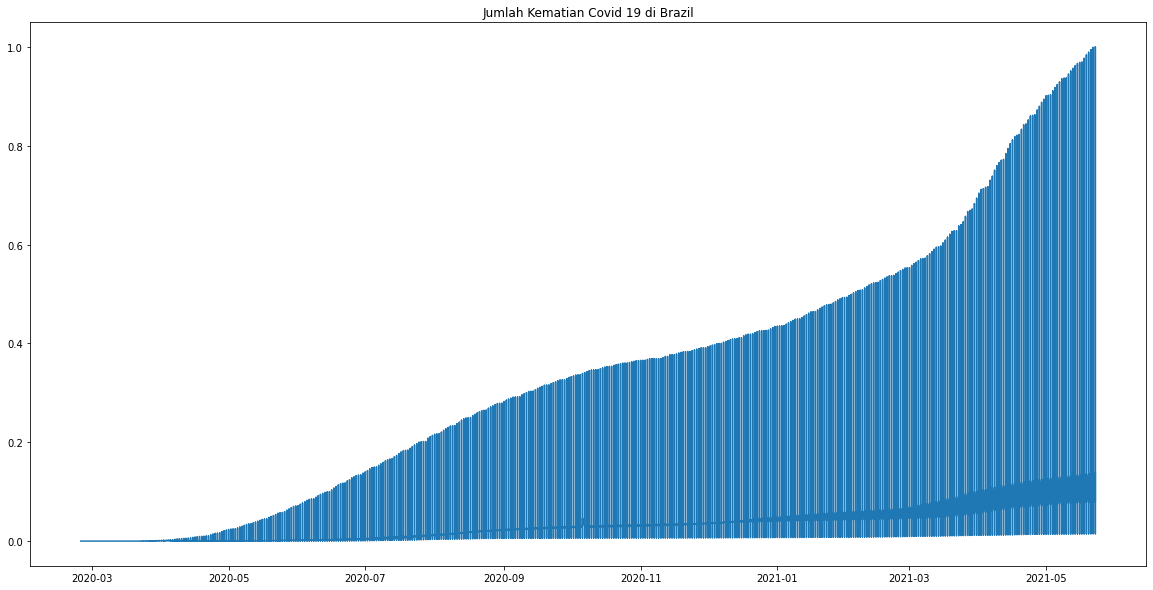

In [ ]:
import matplotlib.pyplot as plt

date = data['date'].values
death = data['deaths'].values

plt.figure(figsize = (20,10))
plt.plot(date, death)
plt.title('Jumlah Kematian Covid 19 di Brazil')

In [ ]:
import tensorflow as tf
def windowedDataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(death, date,
                                                test_size = 0.2,
                                                random_state = 0)


trainSet = windowedDataset(xTrain, window_size = 30, batch_size = 50, shuffle_buffer=1000)
valSet = windowedDataset(xTest, window_size = 30, batch_size = 50, shuffle_buffer=1000)

In [ ]:
class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.10 and logs.get('val_mae') < 0.10):
      self.model.stop_training = True

callbacks = Callback()

In [ ]:
def evalPlot(training):
  plt.style.use('seaborn')
  plt.figure(figsize = (8,6))

  plt.subplot(1,2,1)
  trainAcc = training.history['mae']
  valAcc = training.history['val_mae']
  epoch = range(len(trainAcc))
  trainAccPlot = plt.plot(epoch, trainAcc, 'r')
  valAccPlot = plt.plot(epoch, valAcc, 'b')
  plt.title('MAE training vs MAE Validasi')
  plt.legend(['Train MAE', 'Validation MAE'], loc=0)

  plt.subplot(1,2,2)
  trainLoss = training.history['loss']
  valLoss = training.history['val_loss']
  trainLossPlt = plt.plot(epoch, trainLoss, 'r')
  valLossPlt = plt.plot(epoch, valLoss, 'b')
  plt.title('Loss Training vs Loss Validasi')
  plt.legend(['Train Loss', 'Validation Loss'], loc=0)

In [ ]:
from tensorflow.keras import layers

model = tf.keras.models.Sequential([

    tf.keras.layers.Bidirectional(layers.LSTM(60, return_sequences=True)),
    tf.keras.layers.Bidirectional(layers.LSTM(60)),
    tf.keras.layers.Dense(60, activation = 'tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(30, activation = 'tanh'),
    tf.keras.layers.Dense(10, activation = 'tanh'),
    tf.keras.layers.Dense(1)
])

In [ ]:
from tensorflow import keras
lrSchedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 1e-2,
    decay_steps=9000,
    decay_rate=0.9
)

optimizer = keras.optimizers.SGD(learning_rate = lrSchedule, momentum = 0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])

In [ ]:
history = model.fit(trainSet, 
                    validation_data = valSet,
                    epochs = 100,
                    verbose = 2,
                    callbacks=[callbacks])

Epoch 1/100
178/178 - 22s - loss: 0.0050 - mae: 0.0568 - val_loss: 0.0045 - val_mae: 0.0533


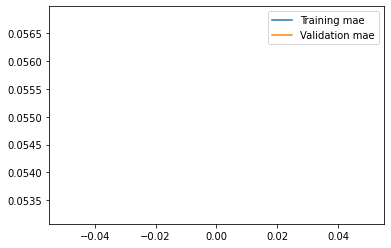

In [ ]:
plt.plot(history.history['mae'], label='Training mae')
plt.plot(history.history['val_mae'], label='Validation mae')
plt.legend()

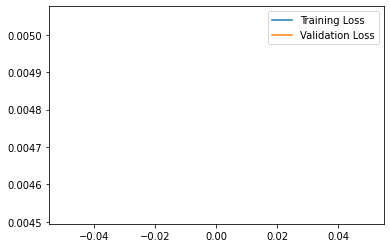

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()